# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## 1 - Business Understanding

#### 
1) The main purpose of studying this dataset is to understand the customer behavior on the Starbucks rewards mobile app.
This data, which is simulated and mimics customer behavior, respects only to one product.
The purpose is to understand the customer behaviour and answer questions like:
- demographic distribution of clients;
- its preferences by age and gender;
who are more likely to respond to promotions, etc.
#### 
2) It will lead us to more conscious decision, including proportion strategies;
#### 
3) That knowledge, that, in this case, respects only to one product, will also allow us to verify if the same kind of behaviour is
observed in other products and related promotions;
#### 
4) The focus in the present work is to analyse data in order to answer some of the enumerated questions (and others) and create a model that will predict, with accuracy, the customer behaviour.


## 2 - Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import datetime
import seaborn as sns
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('Starbucks_data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Starbucks_data/profile.json', orient='records', lines=True)
transcript = pd.read_json('Starbucks_data/transcript.json', orient='records', lines=True)

### 2.1 - First Look at the data

#### 2.1.1 ) All datasets

In [3]:
portfolio


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [141]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [96]:
transcript.tail() #finding number of hours of test duration (714h)

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [5]:
#shape of datasets
print(portfolio.shape)
print(profile.shape)
print(transcript.shape)

(10, 6)
(17000, 5)
(306534, 4)


In [12]:
# find columns with nulls
col_null_portfolio = portfolio.isnull().sum()
col_null_profile = profile.isnull().sum()
col_null_transcript = transcript.isnull().sum()
print(col_null_portfolio)
print(col_null_profile)
print(col_null_transcript)

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
person    0
event     0
value     0
time      0
dtype: int64


In [53]:
#unique values in transcript

event_unique = transcript['event'].unique()
count_by_event = transcript['event'].value_counts()
print(event_unique)
print(count_by_event)


['offer received' 'offer viewed' 'transaction' 'offer completed']
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


### 2.2 - First Look at the data: profile dataset - demographic characterization

In [111]:
#ages interval investigation
profile.age.value_counts() #there is some error with 'age == 118' : assuming it's a null value

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: age, Length: 85, dtype: int64

In [7]:
#remove age==118
profile_drop_null = profile[profile.age != 118]

In [63]:
#percentage of nulls, particularly in age 
age_nulls = profile[profile['age']==118].count()/profile['age'].shape[0]
age_nulls

gender              0.000000
age                 0.127941
id                  0.127941
became_member_on    0.127941
income              0.000000
age_groups          0.000000
dtype: float64

Text(0.5, 1.0, 'Clients per age')

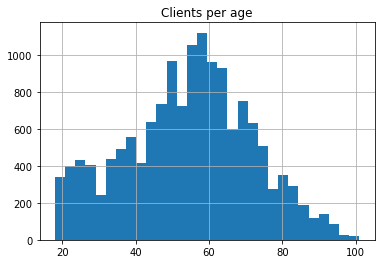

In [8]:
# ages of clients
profile_drop_null.age.hist(bins = 30)
plt.title('Clients per age')

In [106]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Text(0.5, 1.0, 'gender')

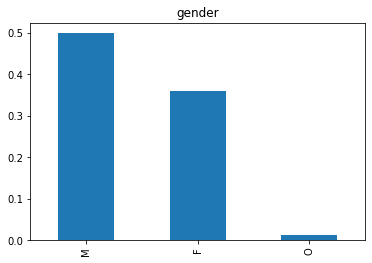

In [32]:
genders= profile.gender.value_counts()
(genders/profile.shape[0]).plot(kind="bar")
plt.title('gender')

In [22]:
profile["age_groups"] = pd.cut(profile['age'], bins=[20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

In [23]:
income_by_age = profile.groupby(['age_groups']).mean()['income'].sort_values().dropna()

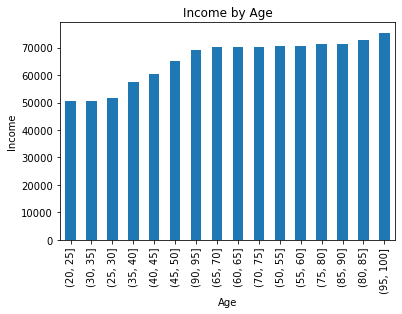

In [28]:
income_by_age.plot(kind="bar")
plt.title('Income by Age')

plt.xlabel('Age')
plt.ylabel("Income")
plt.show()

In [18]:
profile_description = profile[profile.age != 118] #ignore the null values

In [19]:
# look at statistcs description
profile_description[['age', 'income']].describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


## 3 -  Data Preparation

### 3.1 - Clean and transform the data

#### 3.1.1 - Clean and transform portfolio dataframe

In [3]:
def transform_portfolio(dataframe):
    """
    clean and trandfor the portfolio dataframe 
    
    INPUT: dataframe to be cleaned
    OUTPUT: portfolio dataframe transformed
    """  
    #convert number of days into hours: the same metric in column time in transcript dataframe
    portfolio['duration'] = portfolio['duration']*24
    
    #rename column id to offer_id (considering column value of transcript dataframe)
    portfolio.rename(columns={'id':'offer_id'},inplace=True)
    return portfolio

In [4]:
portfolio = transform_portfolio(portfolio)

In [6]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id'],
      dtype='object')

#### 3.1.2 - Clean and transform profile dataframe

In [5]:
def transform_profile(df):
    """
    clean and transform the profile dataframe 
    
    INPUT: dataframe to be cleaned
    OUTPUT: profile dataframe transformed
    """
    # drop all null values
    profile.dropna(inplace = True)
    
    #age classification, also promote data anonimity
    profile.loc[(profile.age < 25) , 'age_range'] = '< 25'
    profile.loc[(profile.age >= 25) & (profile.age < 35) , 'age_range'] = '25-34'
    profile.loc[(profile.age >= 35) & (profile.age < 45) , 'age_range'] = '35-44'
    profile.loc[(profile.age >= 45) & (profile.age < 55) , 'age_range'] = '45-54'
    profile.loc[(profile.age >= 55) & (profile.age < 65) , 'age_range'] = '55-64'
    profile.loc[(profile.age >= 65) & (profile.age < 75) , 'age_range'] = '65-74'
    profile.loc[(profile.age >= 75) & (profile.age <= 85) , 'age_range'] = '75-85'
    profile.loc[(profile.age > 85) , 'age_range'] = '> 85'
   
    #rename id column to costumer_id 
    #(avoid disambiguation with offer_id and match transcript dataframe column)
    profile.rename(columns={'id':'customer_id'},inplace=True)
    
    #convert became_member_on column to datetime
    profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

    return profile


In [6]:
profile = transform_profile(profile)

In [9]:
profile.head()

,gender,age,customer_id,became_member_on,income,age_range
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,55-64
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,75-85
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,65-74
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,65-74
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,55-64


In [11]:
#age mean, median, standard deviation
age_mean = (profile['age'].mean())
age_median = profile['age'].median()
age_st_dev = profile['age'].std()
age_max = profile['age'].max()
age_min = profile['age'].min()
print('The mean of ages is {}.'.format(round(age_mean,1)))
print('The median of ages is {}.'.format(age_median))
print('The standard deviation is {}.'.format(round(age_st_dev,5)))
print('The higher age is {}.'.format(age_max))
print('The lower age is {}'.format(age_min))

The mean of ages is 54.4.
The median of ages is 55.0.
The standard deviation is 17.38371.
The higher age is 101.
The lower age is 18


In [95]:
income_mean = profile['income'].mean()
income_median= profile['income'].median()
income_max = profile['income'].max()
income_min = profile['income'].min()
income_std = profile['income'].std()
print('The mean of income is {}.'.format(round(income_mean,3)))
print('The median of income is {}.'.format(round(income_median,3)))
print('The standard deviation is {}.'.format(round(income_std,3)))
print('The higher income is {}.'.format(income_max))
print('The lower income is {}'.format(income_min))

The mean of income is 65404.992.
The median of income is 64000.0.
The standard deviation is 21598.299.
The higher income is 120000.0.
The lower income is 30000.0


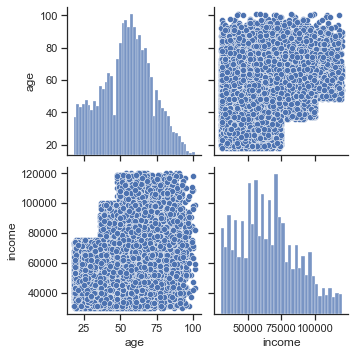

In [72]:
#observe income vs age
sns.set(style="ticks", color_codes=True)    
income_age= profile[['age', 'income']]
g = sns.pairplot(income_age)
plt.show()

In [96]:
older_member_date = profile['became_member_on'].max()
recent_member_date = profile['became_member_on'].min()
print('The older date member is {}.'.format(older_member_date))
print('The recent date member is {}.'.format(recent_member_date))

The older date member is 2018-07-26 00:00:00.
The recent date member is 2013-07-29 00:00:00.


Text(0.5, 1.0, 'Subscriptions through time')

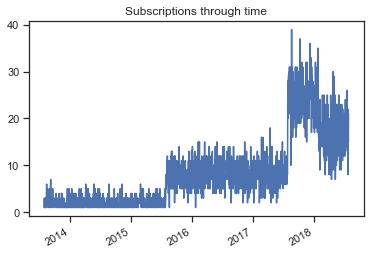

In [106]:
y=profile['became_member_on'].value_counts() 
y.plot.line()
plt.title('Subscriptions through time')

#### 3.1.3 - Clean and transform transcript dataframe

In [28]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
def transform_transcript(df):
    """
    clean and transform the transcript dataframe 
    
    INPUT: dataframe to be cleaned
    OUTPUT: profile dataframe transformed
    """
    #rename person column to customer_id in order to match profile dataframe
    transcript.rename(columns={'person':'customer_id'},inplace=True)
    
    #isolate and process classifications in value column
    values = []
    for val, unique in transcript.iterrows():
        for val in unique['value']:
            if val in values:
                continue
            else:
                values.append(val)
    for val, unique in transcript.iterrows():
        for i in unique['value']:
            if val == 'offer_id' or i == 'offer id': 
                transcript.at[val, 'offer_id'] = unique['value'][i]
            if i == 'amount':
                transcript.at[val, 'amount'] = unique['value'][i]
            if i == 'reward':
                transcript.at[val, 'reward'] = unique['value'][i]
    transcript.drop('value', axis=1, inplace=True)
    
    return transcript

In [8]:
transcript = transform_transcript(transcript)

In [9]:
#replace all null values with 0
transcript = transcript.fillna(0)

In [10]:
transcript.head()

,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [13]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [10]:
#create dummy variables from event
transcript['transaction'] = transcript['event'].apply(lambda event: 1 if 'transaction' in event else 0)
transcript['offer_received'] = transcript['event'].apply(lambda event: 1 if 'offer received' in event else 0)
transcript['offer_viewed'] = transcript['event'].apply(lambda event: 1 if 'offer viewed' in event else 0)
transcript['offer_completed'] = transcript['event'].apply(lambda event: 1 if 'offer completed' in event else 0)

#### 3.1.4 - Merge dataframes

In [11]:
#merge transcript dataframe with profile dataframe by customer_id column
df = pd.merge(transcript, portfolio, on='offer_id',how='outer')

In [14]:
#check columns of df
df.shape

(306534, 15)

In [12]:
#merge new df dataframe with portfolio dataframe
df =pd.merge(df,profile,on='customer_id', how='outer')

In [12]:
df.shape

(306534, 20)

In [13]:
#check df columns
df.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward_x',
       'transaction', 'offer_received', 'offer_viewed', 'offer_completed',
       'reward_y', 'channels', 'difficulty', 'duration', 'offer_type',
       'gender', 'age', 'became_member_on', 'income', 'age_range'],
      dtype='object')

In [13]:
df['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### 3.1.5 - Some more questioning on data

#### i) Count Event type

Text(0.5, 1.0, 'Event type')

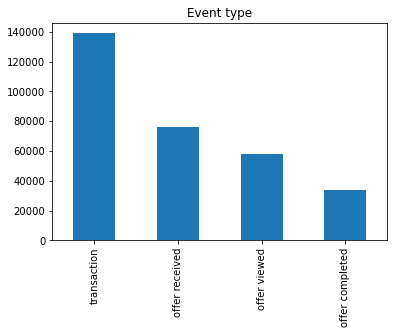

In [12]:
df['event'].value_counts().plot(kind="bar")
plt.title('Event type')

#### ii) Distribution of event type by age

Text(0.5, 1.0, 'Event distribution by Age')

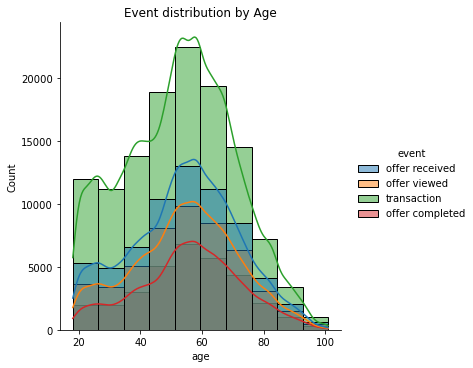

In [14]:
sns.displot(x ='age',kde=True, bins=10,
hue = df['event'] ,data=df)
plt.title('Event distribution by Age')

#### We can observe that people above 55 and under 65 are more likely to view, receive and complete offers, as well as transactions. 

####  iii) Distribution of event type by gender¶

Text(0.5, 1.0, 'Event distribution by gender')

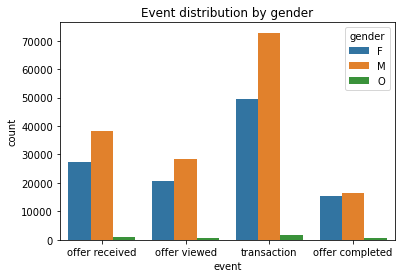

In [19]:
sns.countplot(x= "event", hue= "gender", data=df)
plt.title('Event distribution by gender')

#### iv) Is the age group  [55-64] the most represented group?

In [17]:
round(df['age_range'].value_counts()/df.shape[0],2)

55-64    0.20
45-54    0.18
65-74    0.14
35-44    0.12
25-34    0.09
75-85    0.08
< 25     0.06
> 85     0.03
Name: age_range, dtype: float64

Text(0.5, 1.0, 'Age intervals')

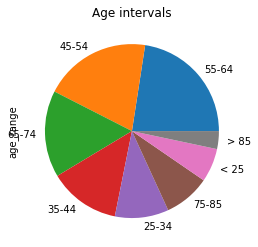

In [16]:
ages =(df['age_range'].value_counts()/df.shape[0])
ages.plot(kind='pie', normalize=True)
plt.title('Age intervals')

#### It is the most represented age group, although it will not explain all the causes of this  most active behaviour.

#### v) Count of offer_type

<AxesSubplot:>

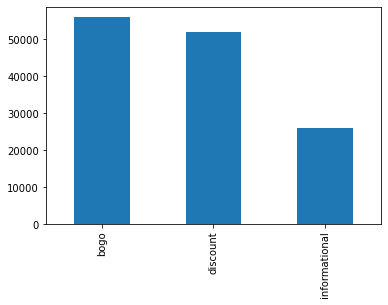

In [117]:
kind_of_offer = df['offer_type'].value_counts()
kind_of_offer.plot(kind="bar")

#### vi) Offer Type by age

Text(0.5, 1.0, 'Offer Type by Age')

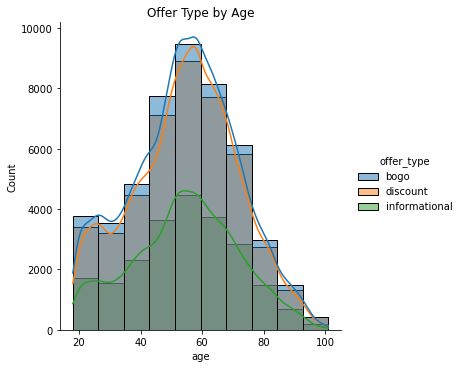

In [118]:
sns.displot(x ='age',kde=True, bins=10,
hue = df['offer_type'] ,data=df)
plt.title('Offer Type by Age')

#### vii) Offer type by Income

Text(0.5, 1.0, 'Offer Type by Income')

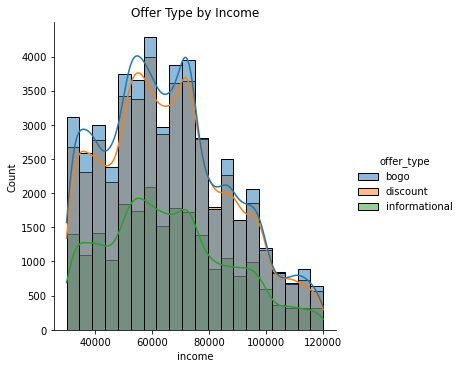

In [122]:
sns.displot(x ='income',kde=True,bins=20,
hue = df['offer_type'] ,data=df)
plt.title('Offer Type by Income')

#### We can't say that the higher the income the higher the usage of offer types, but we can see an accentuated decrease in incomes above 80.000.

#### viii) Offer type by gender

Text(0.5, 1.0, 'Offer Type by gender')

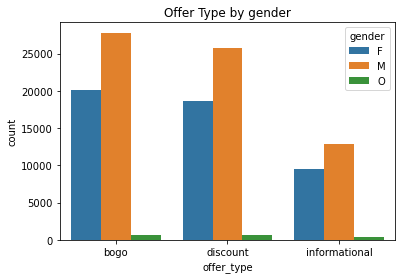

In [16]:
sns.countplot(x= "offer_type", hue= "gender", data=df)
plt.title("Offer Type by gender")

#### ix) Analyse the possible channels usage to reach clients

In [59]:
possible_medium=['web','email','mobile','social']

In [72]:
medium=medium.value_counts().reset_index()
medium.rename(columns={'index': 'channel', 'channels': 'count'}, inplace=True)

In [79]:
def channel_count(df, col1, col2, str_list):
    '''
    INPUT:
    df - the pandas dataframe 
    col_1 - column name we want to look through
    col_2 - column we want to count values from
    str_list - a list where we look in each row
    
    OUTPUT:
    new_df - the dataframe that show up the counting
    '''
    new_df = defaultdict(int)
    for ch in str_list:
        for idx in range(df.shape[0]):
            if ch in df[col1][idx]:
                new_df[ch] += int(df[col2][idx])   
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [82]:
channel_df = channel_count(medium, 'channel', 'count', possible_medium)
channel_df.set_index('channel', inplace=True)

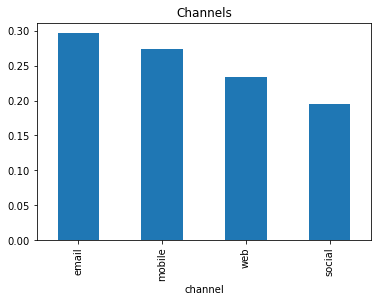

In [83]:
## results with the percent
channel_df['perc'] = channel_df['count']/np.sum(channel_df['count'])
## plot bar chart
(channel_df['perc']).plot(kind="bar")
title= 'Channels'
plt.title(title)
plt.show()

In [21]:
df.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward_x',
       'transaction', 'offer received', 'offer viewed', 'offer completed',
       'reward_y', 'channels', 'difficulty', 'duration', 'offer_type',
       'gender', 'age', 'became_member_on', 'income', 'age_range'],
      dtype='object')

#### x) Check behaviour of Offer Type across Time 

Text(0.5, 1.0, 'Offer Type Over Time')

<Figure size 1008x288 with 0 Axes>

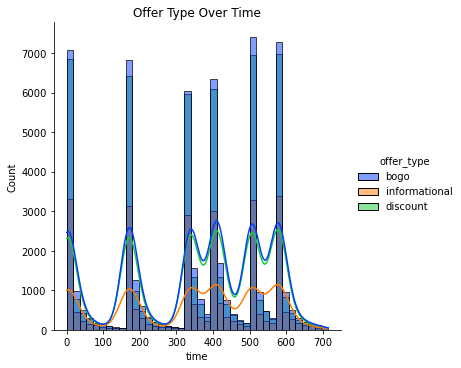

In [23]:
sns.displot(data=df,x ='time',kde=True,bins=40,
hue = df['offer_type'],palette=sns.color_palette('bright',3))
plt.title('Offer Type Over Time')

#### xi) Check behaviour of offer time through date of new members admitions

Text(0.5, 1.0, 'Offer Type vs Became Member Date')

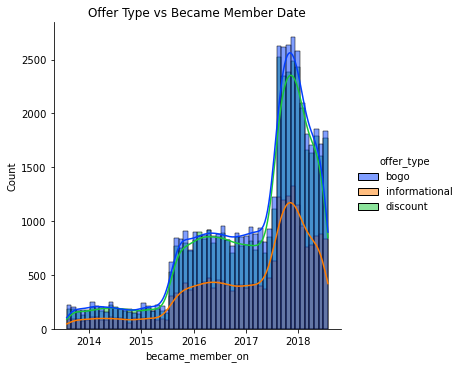

In [31]:
sns.displot(x ='became_member_on',kde=True,bins=56,
hue = df['offer_type'], palette=sns.color_palette('bright',3),data=df)
plt.title('Offer Type vs Became Member Date')

#### xii) Check behaviour of member admission by gender

Text(0.5, 1.0, 'Offer Type Over Time')

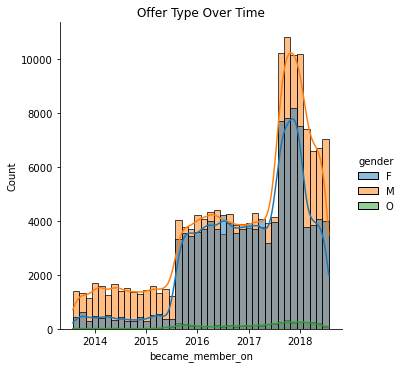

In [18]:
sns.displot(data=df,x ='became_member_on',kde=True,bins=40,
hue = df['gender'])
plt.title('Became Member Date vs gender')

#### xiii) From demographics, check who are more likely to complete an offer

Text(0.5, 1.0, 'Offer Completed by Age Groups')

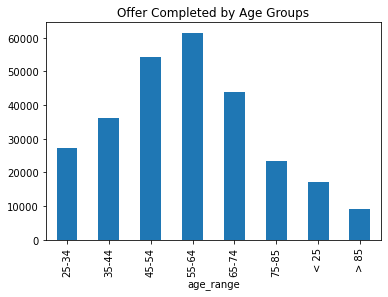

In [45]:
age_complete=df.groupby('age_range')['offer_completed'].count()
age_complete.plot(kind='bar')
plt.title('Offer Completed by Age Groups')

Text(0.5, 1.0, 'Offer Completed by Gender')

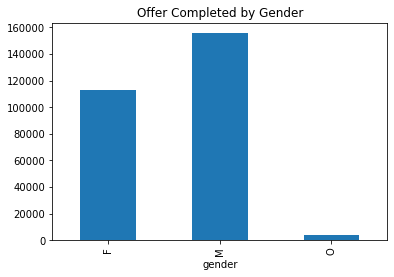

In [34]:
g=df.groupby('gender')['offer_completed'].count()
g.plot(kind='bar')
plt.title('Offer Completed by Gender')

#### xiv) Offer Completed  by Offer Type

Text(0.5, 1.0, 'Offer Completed by Offer Type')

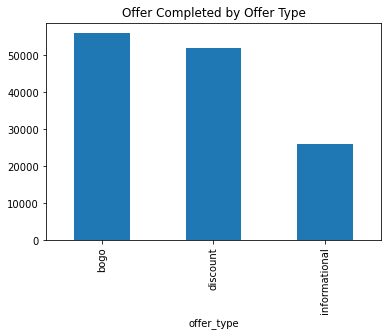

In [46]:
gender_compl=df.groupby('offer_type')['offer_completed'].count()
gender_compl.plot(kind='bar')
plt.title('Offer Completed by Offer Type')

#### We can see that those who have received 'bogo' or 'discount' were more likely to complete an offer.

#### xv) Find correlations in dataframe

In [14]:
df=df.fillna(0)
df.drop(['reward_y'],axis=1, inplace=True)

In [15]:
df.corr()

,time,amount,reward_x,transaction,offer_received,offer_viewed,offer_completed,difficulty,duration,age,income
time,1.000000,0.023626,0.047534,0.069098,-0.097121,-0.029075,0.060702,-0.080217,-0.098907,0.004654,0.000975
amount,0.023626,1.000000,-0.080783,0.298108,-0.156237,-0.130751,-0.095210,-0.175891,-0.217989,0.083167,0.134200
reward_x,0.047534,-0.080783,1.000000,-0.270986,-0.171283,-0.143342,0.848470,-0.192830,-0.238981,0.085733,0.118928
transaction,0.069098,0.298108,-0.270986,1.000000,-0.524097,-0.438602,-0.319382,-0.590025,-0.731241,-0.034062,-0.066641
offer_received,-0.097121,-0.156237,-0.171283,-0.524097,1.000000,-0.277229,-0.201873,0.504420,0.606979,-0.012370,-0.005174
offer_viewed,-0.029075,-0.130751,-0.143342,-0.438602,-0.277229,1.000000,-0.168942,0.375030,0.484880,-0.014464,-0.006408
offer_completed,0.060702,-0.095210,0.848470,-0.319382,-0.201873,-0.168942,1.000000,-0.227267,-0.281662,0.089522,0.121405
difficulty,-0.080217,-0.175891,-0.192830,-0.590025,0.504420,0.375030,-0.227267,1.000000,0.889699,-0.016226,-0.005277
duration,-0.098907,-0.217989,-0.238981,-0.731241,0.606979,0.484880,-0.281662,0.889699,1.000000,-0.019624,-0.007479
age,0.004654,0.083167,0.085733,-0.034062,-0.012370,-0.014464,0.089522,-0.016226,-0.019624,1.000000,0.653439


#### we can observe significant positive correlations (>0.5) between:
#### - age and income (0.6534)
#### - duration an difficulty (0.8897)
#### - reward and difficulty (0.7385)
#### - duration and reward (0.6573)
#### - duration and offer_received (0.6070)
#### - difficulty and duration (0.8897)
#### - offer_completed and reward(0.848470)
#### There is also a low correlation (<0.5) between offer_viewed and duration (0.4848)

#### we can also observe significant negative correlations  between:
#### - duration and transaction (-0.7312)


### 4 -  Modeling the data

#### I) Final cleanning: one more step - clean the dataset before modeling

#### a) drop some columns

In [16]:
# more clean on df
df.drop(['event'],axis=1, inplace=True)
df.rename(columns={'reward_x':'reward'},inplace=True)

In [17]:
#also remove channels, which we have already analyse
df.drop(['channels'],axis=1, inplace=True)

#### b) rearrange some variables (from string to integer type)

#### . rearrange ages with integers, replacing the strings
#### 18 - 25 : 1;
#### 25 - 34: 2;
#### 35 - 44: 3;
#### 45 - 54: 4;
#### 55 - 64: 5;
#### 65 - 74: 6;
#### 75 - 84: 7;
#### > 85 :8;

In [18]:
df.loc[(df.age < 25) , 'age_range'] = 1
df.loc[(df.age >= 25) & (df.age < 35) , 'age_range'] = 2
df.loc[(df.age >= 35) & (df.age < 45) , 'age_range'] = 3
df.loc[(df.age >= 45) & (df.age < 55) , 'age_range'] = 4
df.loc[(df.age >= 55) & (df.age < 65) , 'age_range'] = 5
df.loc[(df.age >= 65) & (df.age < 75) , 'age_range'] = 6
df.loc[(df.age >= 75) & (df.age <= 85) , 'age_range'] = 7
df.loc[(df.age > 85) , 'age_range'] = 8

In [19]:
#remove age, which we have already analyse
df.drop(['age'],axis=1, inplace=True)

#### . rearrange offer_id and costumer_id

In [20]:
# replace with integer the string in costumer_id
costm_id = df['customer_id'].astype('category').cat.categories.tolist()
costm_id = {'customer_id' : {c: i for c,i in zip(costm_id,list(range(1,len(costm_id)+1)))}}

# replace categorical labels with numeric
df.replace(costm_id, inplace=True)

In [21]:
# replace with integer the string in costumer_id
off_id = df['offer_id'].astype('category').cat.categories.tolist()
off_id = {'offer_id' : {c: i for c,i in zip(off_id,list(range(1,len(off_id)+1)))}}

# replace categorical labels with numeric
df.replace(off_id, inplace=True)

#### . replace strings in offer_type:
#### 1: bogo
#### 2: discount
#### 3: informational

In [23]:
df.loc[(df.offer_type == 'bogo') , 'offer_type'] = 1
df.loc[(df.offer_type == 'discount') , 'offer_type'] = 2
df.loc[(df.offer_type == 'informational') , 'offer_type'] = 3

#### replace gender letters by numbers:
#### F -> 1
#### M -> 2
#### O -> 3

In [37]:
df.loc[(df.gender == 'F') , 'gender'] = 1
df.loc[(df.gender == 'M') , 'gender'] = 2
df.loc[(df.gender == 'O') , 'gender'] = 3

#### 4.1) X and Y definition;
#### Transaction will be excluded

In [38]:
#Define X and Y
#we'll not consider transaction 
#we'll not consider date of membership (analysed appart)

X = df[['customer_id', 'time', 'offer_id', 'amount', 'reward', 'difficulty',
        'duration', 'offer_type', 'gender', 'income','age_range']]
y = df[['offer_received', 'offer_viewed', 'offer_completed']]

In [39]:
X.head()

,customer_id,time,offer_id,amount,reward,difficulty,duration,offer_type,gender,income,age_range
0,7997,0,8,0.0,0.0,5.0,168.0,1,1,100000.0,7
1,7997,6,8,0.0,0.0,5.0,168.0,1,1,100000.0,7
2,7997,504,10,0.0,0.0,5.0,120.0,1,1,100000.0,7
3,7997,582,10,0.0,0.0,5.0,120.0,1,1,100000.0,7
4,7997,408,9,0.0,0.0,10.0,168.0,1,1,100000.0,7


#### II) Start modeling data

#### Split into train and test set

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)


#### Check shape of train and test set

In [41]:
print("The train set has {} rows".format(X_train.shape[0]))
print("The test set has {} rows".format(X_test.shape[0]))

The train set has 214573 rows
The test set has 91961 rows


#### RandomForestClassifier

In [60]:
#create pipeline
pipeline = Pipeline([
    ('clf',MultiOutputClassifier(RandomForestClassifier()))
])

In [61]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

In [62]:
# predict y
y_pred = pipeline.predict(X_test)

#### Test the model

In [63]:
# find accuracy
accuracy = (y_pred == y_test).mean()
print(accuracy)

offer_received     0.905601
offer_viewed       0.900121
offer_completed    1.000000
dtype: float64


In [41]:
target_names=y.columns
print(classification_report(y_test, y_pred, target_names = target_names))

                 precision    recall  f1-score   support

 offer_received       0.79      0.83      0.81     22886
   offer_viewed       0.76      0.70      0.73     17295
offer_completed       1.00      1.00      1.00     10141

      micro avg       0.82      0.82      0.82     50322
      macro avg       0.85      0.84      0.85     50322
   weighted avg       0.82      0.82      0.82     50322
    samples avg       0.45      0.45      0.45     50322



/Users/anateresaneto/opt/miniconda3/envs/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anateresaneto/opt/miniconda3/envs/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### KNeighborsClassifier

In [56]:
#create pipeline
pipeline = Pipeline([
    ('clf',MultiOutputClassifier(KNeighborsClassifier()))
])

In [57]:
#fit pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier()))])

In [58]:
# predict y
y_pred = pipeline.predict(X_test)

#### Test the model

In [59]:
#find accuracy to first evaluation of the model
accuracy = (y_pred == y_test).mean()
print(accuracy)

offer_received     0.736606
offer_viewed       0.755984
offer_completed    0.879112
dtype: float64


In [46]:
target_names=y.columns
print(classification_report(y_test, y_pred, target_names = target_names))

                 precision    recall  f1-score   support

 offer_received       0.47      0.41      0.44     22886
   offer_viewed       0.23      0.13      0.17     17295
offer_completed       0.22      0.04      0.06     10141

      micro avg       0.38      0.24      0.30     50322
      macro avg       0.31      0.19      0.22     50322
   weighted avg       0.34      0.24      0.27     50322
    samples avg       0.13      0.13      0.13     50322



/Users/anateresaneto/opt/miniconda3/envs/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anateresaneto/opt/miniconda3/envs/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### AdaboostClassifier

In [51]:
from sklearn.ensemble import AdaBoostClassifier
#create pipeline
pipeline = Pipeline([
    ('clf',MultiOutputClassifier(AdaBoostClassifier()))
])

In [52]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf', MultiOutputClassifier(estimator=AdaBoostClassifier()))])

In [53]:
y_pred = pipeline.predict(X_test)

#### Test the model

In [54]:
#find accuracy to first evaluation of the model
accuracy = (y_pred == y_test).mean()
print(accuracy)

offer_received     0.957819
offer_viewed       0.957819
offer_completed    1.000000
dtype: float64


In [55]:
target_names=y.columns
print(classification_report(y_test, y_pred, target_names = target_names))

                 precision    recall  f1-score   support

 offer_received       0.86      1.00      0.92     22886
   offer_viewed       1.00      0.78      0.87     17295
offer_completed       1.00      1.00      1.00     10141

      micro avg       0.92      0.92      0.92     50322
      macro avg       0.95      0.93      0.93     50322
   weighted avg       0.93      0.92      0.92     50322
    samples avg       0.51      0.51      0.51     50322



/Users/anateresaneto/opt/miniconda3/envs/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anateresaneto/opt/miniconda3/envs/my_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5 - Evaluating the results

#### AdaboostClassifier combined with MultiOutputClassifier has higher accuracy than KneighborClassifier and better results in precision and f1-score, as we have seen in the classification report.

|           |RandomForestClassifier   | RandomForestRegressor  | AdaBoostClassifier     |  
|-----------|-------------------------|------------------------|------------------------|
| accuracy  |offer_received:  0.905601|offer_received:0.736606 |offer_received:0.957819 |   
|           |offer_viewed:    0.900121|offer_viewed: 0.755984  |offer_viewed:0.957819   |                
|           |offer_completed: 1.000000|offer_completed:0.879112|offer_completed:1.000000|      
|-----------|-------------------------|------------------------|------------------------|      
| precision |offer_received:  0.79    |offer_received:  0.47   | offer_received:  0.86  |  
|           |offer_viewed:    0.76    |offer_viewed:    0.23   | offer_viewed:    1.00  |
|           |offer_completed: 1.00    |offer_completed: 0.22   | offer_viewed:    1.00  |
|-----------|-------------------------|------------------------|------------------------|
| recall    | offer_received:  0.83   |offer_received:  0.41   | offer_received:  1.00  |   
|           | offer_viewed:    0.70   |offer_viewed:    0.13   | offer_viewed:    0.78  |
|           | offer_completed: 1.00   |offer_completed: 0.04   | offer_completed: 1.00  |                       
|-----------|-------------------------|------------------------|------------------------|
| f1-score  | offer_received:  0.81   |offer_received:  0.44   |offer_received:   0.92  |   
|           | offer_viewed:    0.73   |offer_viewed:    0.17   |offer_viewed:     0.87  |
|           | offer_completed: 1.00   |offer_completed: 0.06   |offer_completed:  1.00  | 


#### Some improvements to the present model would be:

#### - Implement A/B tests;
#### - cross with samples other datasets of more products, to analyse more general trends or check if the ones identifyied are mantained;
#### - Implementation of grid searchCV could optimize the best parameters and improve model performance, but we also must be carefull to don' overfit. 
#### - Implement a different aproach, based on a recommendation engine, in order to automatically send best offers to clients, based on their choices. This aproach maybe will be even better if information relative to more products is presented.